In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# split data in 60%/20%/20% train/validation/test sets
valid_set_size_percentage = 20 
test_set_size_percentage = 20 

from pandas import read_csv

Using TensorFlow backend.


In [2]:
df = read_csv('dataset/Iron ore fines 62% Fe CFR Futures Historical Data.csv')

In [3]:
df = df.drop(['Vol.', 'Change %'], axis=1)
s = 0
l = 714
for i in range(round(len(df)/2)):
    s_temp = df.iloc[s].copy()
    l_temp = df.iloc[l].copy()
    df.iloc[s] = l_temp
    df.iloc[l] = s_temp
    s = s + 1
    l = l -1

In [4]:
from dateutil import parser
for i in range(len(df['Date'])):
    dt = parser.parse(df['Date'][i])
    df['Date'][i] = dt.strftime("%Y-%m-%d")
    #print(train['Date'][i], i)
df = df.set_index('Date')

C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [5]:
start = min(df.index.tolist())
end = max(df.index.tolist())
print("Start date: ", start, ", End date: ", end)

Start date:  2016-01-04 , End date:  2018-10-16


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 715 entries, 2016-01-04 to 2018-10-16
Data columns (total 4 columns):
Price    715 non-null float64
Open     715 non-null float64
High     715 non-null float64
Low      715 non-null float64
dtypes: float64(4)
memory usage: 27.9+ KB


In [7]:
w = 20 # window size 

In [8]:
temp = df.copy()

In [9]:
roll_df = df.rolling(window=w).mean()
roll_df.dropna(inplace=True)
roll_df.describe()

,Price,Open,High,Low
count,696.000000,696.000000,696.000000,696.000000
mean,65.418325,65.418325,65.879064,64.334416
std,10.073146,10.073146,10.101760,9.997210
min,40.857500,40.857500,41.293500,37.638500
25%,57.754875,57.754875,58.168625,56.543500
50%,65.429500,65.429500,65.783750,65.007750
75%,73.021375,73.021375,73.718750,71.622375
max,87.637000,87.637000,88.162500,86.695000


In [10]:
# function for min-max normalization of stock
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
def normalize_data(df):
    df['Price'] = min_max_scaler.fit_transform(df.Price.values.reshape(-1,1))
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    return df

In [11]:
# normalize stock
df_stock_norm = df.copy()
df_stock_norm = normalize_data(df_stock_norm)
df_stock_norm.head()

,Price,Open,High,Low
Date,,,,
2016-01-04,0.043804,0.043804,0.061815,0.081705
2016-01-05,0.040253,0.040253,0.054835,0.071936
2016-01-06,0.028414,0.028414,0.030907,0.049734
2016-01-07,0.029006,0.029006,0.019940,0.001776
2016-01-08,0.022494,0.022494,0.021934,0.000000


In [12]:
len(df_stock_norm)

715

In [31]:
# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array shape (1762,4)
    #print(data_raw.shape)
    data = []
    cnt = 0
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    
    data = np.array(data);
   # print(data.shape)
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    print(x_train[1].shape, y_train[1].shape)
    print(data[0])
    print(x_train[0],y_train[0])
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    print(x_valid.shape)
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


In [32]:
# create train, test data
seq_len = 19 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len+1)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

(19, 4) (4,)
[[0.04380426 0.04380426 0.06181456 0.08170515]
 [0.04025257 0.04025257 0.05483549 0.07193606]
 [0.02841358 0.02841358 0.03090728 0.04973357]
 [0.02900552 0.02900552 0.01994018 0.0017762 ]
 [0.02249408 0.02249408 0.0219342  0.        ]
 [0.00986582 0.00986582 0.01395813 0.0017762 ]
 [0.         0.         0.         0.01420959]
 [0.00789266 0.00789266 0.         0.01420959]
 [0.01282557 0.01282557 0.00797607 0.02131439]
 [0.0191397  0.0191397  0.01196411 0.03996448]
 [0.04577743 0.04577743 0.04985045 0.08081705]
 [0.04005525 0.04005525 0.03788634 0.09680284]
 [0.02466456 0.02466456 0.02991027 0.13499112]
 [0.02841358 0.02841358 0.03489531 0.15186501]
 [0.03137332 0.03137332 0.02133599 0.13978686]
 [0.02920284 0.02920284 0.02791625 0.11190053]
 [0.03058406 0.03058406 0.01894317 0.13765542]
 [0.03295185 0.03295185 0.02492522 0.14298401]
 [0.0335438  0.0335438  0.02352941 0.14174067]
 [0.03334649 0.03334649 0.02333001 0.14156306]]
[[0.04380426 0.04380426 0.06181456 0.08170515]

C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
x_train.shape

(417, 19, 4)

In [34]:
y_train[1]

array([0.0753749 , 0.0753749 , 0.06979063, 0.1660746 ])

In [35]:
# Choose only  prices
x_train, y_train, x_valid, y_valid, x_test, y_test = x_train[:,:,0], y_train[:,0], x_valid[:,:,0], y_valid[:,0], x_test[:,:,0], y_test[:,0]
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (417, 19)
y_train.shape =  (417,)
x_valid.shape =  (139, 19)
y_valid.shape =  (139,)
x_test.shape =  (139, 19)
y_test.shape =  (139,)


In [38]:
x_train[0]

array([0.04380426, 0.04025257, 0.02841358, 0.02900552, 0.02249408,
       0.00986582, 0.        , 0.00789266, 0.01282557, 0.0191397 ,
       0.04577743, 0.04005525, 0.02466456, 0.02841358, 0.03137332,
       0.02920284, 0.03058406, 0.03295185, 0.0335438 ])

In [41]:
y_train[0]

0.033346487766377386

In [84]:
#Build the model
# Predict every 20th time step
model = Sequential()
model.add(LSTM(256,input_shape=(seq_len,1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse', metrics=['accuracy'])

In [85]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 280,705
Trainable params: 280,705
Non-trainable params: 0
_________________________________________________________________


In [86]:
x_train.shape

(417, 19)

In [87]:
#Reshape data for (Sample,Timestep,Features) 
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_valid = x_valid.reshape((x_valid.shape[0],x_valid.shape[1],1))
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],1))

In [88]:
x_train.shape

(417, 19, 1)

In [89]:
epoch_size = 2

In [90]:
#Fit model with history to check for overfitting
history = model.fit(x_train,y_train,epochs=epoch_size,validation_data=(x_valid,y_valid),shuffle=False)

Train on 417 samples, validate on 139 samples
Epoch 1/2
417/417 [==============================] - 2s 4ms/step - loss: 0.0161 - acc: 0.0024 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 2/2
417/417 [==============================] - 1s 1ms/step - loss: 0.0071 - acc: 0.0024 - val_loss: 0.0055 - val_acc: 0.0000e+00


In [91]:
x_test.shape

(139, 19, 1)

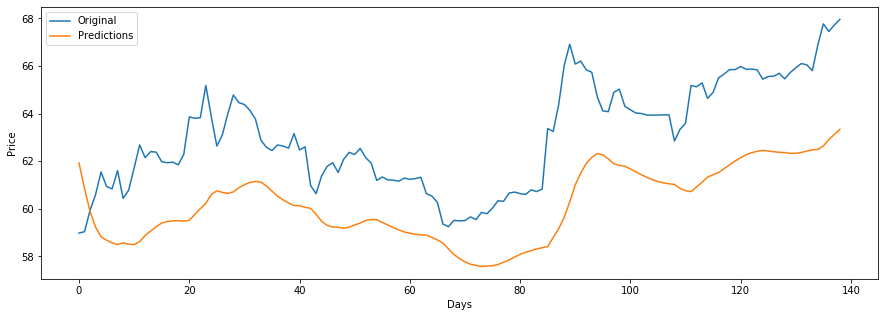

In [92]:
# Visualise predictions
Xt = model.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot( np.arange(y_test.shape[0]), min_max_scaler.inverse_transform(y_test.reshape(-1,1)),label='Original')
plt.plot(np.arange(y_test.shape[0]), min_max_scaler.inverse_transform(Xt), label ='Predictions')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

In [93]:
Xt

array([[0.51026   ],
       [0.49118045],
       [0.47431666],
       [0.4624253 ],
       [0.4551101 ],
       [0.45263842],
       [0.4505977 ],
       [0.44938087],
       [0.45068243],
       [0.44959345],
       [0.449367  ],
       [0.45154375],
       [0.45619348],
       [0.45941117],
       [0.46270967],
       [0.4654128 ],
       [0.466574  ],
       [0.46708918],
       [0.4672274 ],
       [0.46687752],
       [0.46744692],
       [0.47185516],
       [0.47615963],
       [0.48008752],
       [0.48669505],
       [0.48947555],
       [0.48830453],
       [0.4875174 ],
       [0.48868966],
       [0.49177903],
       [0.4940262 ],
       [0.4957412 ],
       [0.49646732],
       [0.49595845],
       [0.49305058],
       [0.48931342],
       [0.48548934],
       [0.48270062],
       [0.48039973],
       [0.4784301 ],
       [0.47843134],
       [0.4771856 ],
       [0.4764197 ],
       [0.47195023],
       [0.46671528],
       [0.46374303],
       [0.4625161 ],
       [0.462

In [94]:
y_test

array([0.45797159, 0.45895817, 0.47474349, 0.48658248, 0.5035517 ,
       0.49269929, 0.49092344, 0.50453828, 0.48382005, 0.48993686,
       0.50651144, 0.52367798, 0.51420679, 0.51874507, 0.51835043,
       0.51124704, 0.51045777, 0.51085241, 0.50887924, 0.51657459,
       0.54459353, 0.54360695, 0.54400158, 0.56807419, 0.54459353,
       0.52288871, 0.53117601, 0.54715864, 0.5609708 , 0.55524862,
       0.5538674 , 0.54952644, 0.543015  , 0.52722968, 0.52190213,
       0.51953433, 0.52367798, 0.52288871, 0.52131018, 0.53216259,
       0.51992897, 0.52229676, 0.49348856, 0.48737174, 0.50059195,
       0.50769534, 0.51045777, 0.50315706, 0.51302289, 0.51815312,
       0.51657459, 0.52111287, 0.51420679, 0.51006314, 0.49723757,
       0.49980268, 0.4976322 , 0.49743489, 0.49664562, 0.49901342,
       0.49802684, 0.49861878, 0.49960537, 0.48737174, 0.4855959 ,
       0.4808603 , 0.46468035, 0.46270718, 0.46744278, 0.46704815,
       0.46724546, 0.47000789, 0.46803473, 0.47336227, 0.47237

In [96]:

# # Bug fixed at here, please update the denormalize function to this one
def denormalize(df, normalized_value): 
    df = df['Price'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, Xt)
newy_test = denormalize(df, y_test)

In [97]:
newy_test

array([[62.69],
       [62.74],
       [63.54],
       [64.14],
       [65.  ],
       [64.45],
       [64.36],
       [65.05],
       [64.  ],
       [64.31],
       [65.15],
       [66.02],
       [65.54],
       [65.77],
       [65.75],
       [65.39],
       [65.35],
       [65.37],
       [65.27],
       [65.66],
       [67.08],
       [67.03],
       [67.05],
       [68.27],
       [67.08],
       [65.98],
       [66.4 ],
       [67.21],
       [67.91],
       [67.62],
       [67.55],
       [67.33],
       [67.  ],
       [66.2 ],
       [65.93],
       [65.81],
       [66.02],
       [65.98],
       [65.9 ],
       [66.45],
       [65.83],
       [65.95],
       [64.49],
       [64.18],
       [64.85],
       [65.21],
       [65.35],
       [64.98],
       [65.48],
       [65.74],
       [65.66],
       [65.89],
       [65.54],
       [65.33],
       [64.68],
       [64.81],
       [64.7 ],
       [64.69],
       [64.65],
       [64.77],
       [64.72],
       [64.75],
       [

In [98]:
newp

array([[65.33997 ],
       [64.373024],
       [63.518364],
       [62.91571 ],
       [62.54498 ],
       [62.419712],
       [62.316288],
       [62.254623],
       [62.320583],
       [62.265396],
       [62.253918],
       [62.364235],
       [62.599884],
       [62.76296 ],
       [62.930126],
       [63.067116],
       [63.12597 ],
       [63.15208 ],
       [63.15908 ],
       [63.14135 ],
       [63.17021 ],
       [63.39362 ],
       [63.611767],
       [63.810837],
       [64.145706],
       [64.28662 ],
       [64.22727 ],
       [64.18738 ],
       [64.246796],
       [64.40336 ],
       [64.51725 ],
       [64.604164],
       [64.64097 ],
       [64.61517 ],
       [64.467804],
       [64.278404],
       [64.0846  ],
       [63.943264],
       [63.82666 ],
       [63.726833],
       [63.726902],
       [63.663765],
       [63.62495 ],
       [63.398434],
       [63.13313 ],
       [62.982494],
       [62.920315],
       [62.91086 ],
       [62.872555],
       [62.911453],


In [99]:
temp

,Price,Open,High,Low
Date,,,,
2016-01-04,41.70,41.70,43.10,37.80
2016-01-05,41.52,41.52,42.75,37.25
2016-01-06,40.92,40.92,41.55,36.00
2016-01-07,40.95,40.95,41.00,33.30
2016-01-08,40.62,40.62,41.10,33.20
2016-01-11,39.98,39.98,40.70,33.30
2016-01-12,39.48,39.48,40.00,34.00
2016-01-13,39.88,39.88,40.00,34.00
2016-01-14,40.13,40.13,40.40,34.40


In [ ]:
#----------------------------------------------------------------------------------------------------------#

In [95]:
df.head()

,date,open,low,high,volume,adj close
544,2010-01-04,30.620001,30.590000,31.100000,38409100.0,30.950001
1012,2010-01-05,30.850000,30.639999,31.100000,49749600.0,30.959999
1480,2010-01-06,30.879999,30.520000,31.080000,58182400.0,30.770000
1948,2010-01-07,30.629999,30.190001,30.700001,50559700.0,30.450001
2416,2010-01-08,30.280001,30.240000,30.879999,51197400.0,30.660000


In [98]:
pp = np.array(df['open'])

In [99]:
pp

array([30.620001, 30.85    , 30.879999, ..., 63.400002, 62.860001,
       62.959999])

In [106]:
# function for min-max normalization of stock
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
def normalize_data(df):
    return min_max_scaler.fit_transform(df.reshape(-1,1))
    #return df

In [107]:
df_stock_norm = normalize_data(pp)
#df_stock_norm.head()

In [108]:
df_stock_norm

array([[0.1847853 ],
       [0.19042945],
       [0.19116562],
       ...,
       [0.9892025 ],
       [0.97595094],
       [0.97840488]])

In [109]:
min_max_scaler.inverse_transform(df_stock_norm)

array([[30.620001],
       [30.85    ],
       [30.879999],
       ...,
       [63.400002],
       [62.860001],
       [62.959999]])

In [91]:
df = pd.read_csv("dataset/prices-split-adjusted.csv", index_col = 0)
df = df[df.symbol == 'MSFT']
df.drop(['symbol'],1,inplace=True)

# # Bug fixed at here, please update the denormalize function to this one
def denormalize(df, normalized_value): 
    df = df['open'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

#newp = denormalize(df, Xt)
newy_test = denormalize(df, df_stock_norm.open)

AttributeError: 'Series' object has no attribute 'reshape'

In [ ]:
newy_test

In [90]:
df_stock_norm.open

date
2010-01-04    0.184785
2010-01-05    0.190429
2010-01-06    0.191166
2010-01-07    0.185031
2010-01-08    0.176442
2010-01-11    0.186994
2010-01-12    0.173252
2010-01-13    0.175951
2010-01-14    0.177178
2010-01-15    0.196074
2010-01-19    0.187975
2010-01-20    0.189448
2010-01-21    0.184540
2010-01-22    0.169571
2010-01-25    0.150920
2010-01-26    0.149939
2010-01-27    0.153620
2010-01-28    0.165644
2010-01-29    0.167117
2010-02-01    0.130061
2010-02-02    0.129571
2010-02-03    0.126871
2010-02-04    0.129816
2010-02-05    0.120491
2010-02-08    0.120736
2010-02-09    0.119755
2010-02-10    0.121227
2010-02-11    0.118773
2010-02-12    0.115828
2010-02-16    0.123681
                ...   
2016-11-17    0.915828
2016-11-18    0.924908
2016-11-21    0.918037
2016-11-22    0.929816
2016-11-23    0.930552
2016-11-25    0.913129
2016-11-28    0.914110
2016-11-29    0.921718
2016-11-30    0.926871
2016-12-01    0.908466
2016-12-02    0.883190
2016-12-05    0.898405
2016-1